# Homework_2: Аналитика текста

In [ ]:
%pip install torch

In [163]:
import glob
import re
from IPython.display import display

import numpy as np
import pandas as pd

import spacy
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

## Часть 1: Анализ текста с помощью TF-IDF

### 1. Рассчитайте метрику TF-IDF для любых трех песен на выбранном вами языке

Вес задания: 30%

In [3]:
# Открыть файлы с песнями
file_paths = glob.glob('data/song*.txt')
pattern = r"\[.*\]"

texts = []

for path in file_paths:
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read()
        text = re.sub(pattern, '', text)
        texts.append(text)

In [5]:
nlp = spacy.load("ru_core_news_md")

In [6]:
def process_text(text):
    text = text.lower()
    doc = nlp(text)
    lemma_doc = [token.lemma_ for token in doc if
                 not token.is_punct
                 and not token.is_space
                 and not token.is_stop]
    return lemma_doc

texts_lemma = [process_text(t) for t in texts]

In [132]:
def rate_vectorization(text_matrix, feature_names, name, count=5):
    for i in range(text_matrix.shape[0]):
        weights = text_matrix[i].flatten()
        
        df = pd.DataFrame({'word': feature_names,
                           name: weights})
        
        df = df[df[name] > 0].sort_values(by=name, ascending=False)
        df = df.reset_index(drop=True)
    
        print(f"song{i}.txt")
        display(df.head(count))

In [133]:
texts_joined = [" ".join(text) for text in texts_lemma]

In [134]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(texts_joined)
tfidf_matrix = tfidf_matrix.toarray()
tfidf_features = tfidf_vectorizer.get_feature_names_out()

rate_vectorization(tfidf_matrix, tfidf_features, 'tfidf')

song0.txt


,word,tfidf
0,почитай,0.318650
1,старший,0.318650
2,важный,0.136564
3,величина,0.136564
4,мемасиков,0.136564


song1.txt


,word,tfidf
0,видеть,0.221600
1,эмси,0.147733
2,рэпер,0.147733
3,рэп,0.147733
4,искать,0.110800


song2.txt


,word,tfidf
0,этаж,0.281674
1,тело,0.281674
2,гараж,0.211256
3,дешёвый,0.211256
4,микрозелень,0.211256


### 2. Сравните TF-IDF с другими методами векторизации текста, такими как Count Vectorizer, Word2Vec или Doc2Vec

Вес задания: 30%

In [135]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(texts_joined)
count_matrix = count_matrix.toarray()
count_features = count_vectorizer.get_feature_names_out()

In [136]:
w2v_model = Word2Vec(sentences=texts_lemma, window=5, vector_size=100, min_count=1)

def get_song_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

w2v_matrix = np.array([get_song_embedding(t, w2v_model) for t in texts_lemma])

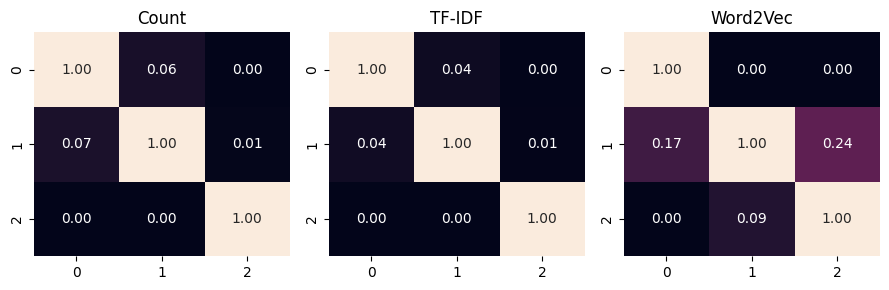

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
methods = [
    ("Count", count_matrix),
    ("TF-IDF", tfidf_matrix),
    ("Word2Vec", w2v_matrix)
]

for ax, (name, data) in zip(axes.flatten(), methods):
    sim = cosine_similarity(data)
    scaler = MinMaxScaler()
    sim = scaler.fit_transform(sim)
    sns.heatmap(sim, annot=True, fmt=".2f", ax=ax, cbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()

In [139]:
# Резльтаты первых двух методов почти идентичны, поскольку
# общий набор текстов для данных методов слишком мал.
# Word2Vec в данной задаче справился лучше других методов.
# Остальные методы тоже работают, но им требуется больше данных,
# чтобы дать разумные результаты

### 3. Проведите исследование, используя полученные преобразованные данные

Какие слова/фразы встречаются чаще всего, а какие реже.

Вес задания: 20%

In [157]:
# Отображение 10 наиболее часто встречающихся слов
word_counts = count_matrix.sum(axis=0)
word_names = count_features

df = pd.DataFrame({'word': word_names, 'count': word_counts})
df = df.sort_values(by='count', ascending=False)
df = df.reset_index(drop=True)
df.head(10)

,word,count
0,старший,7
1,почитай,7
2,видеть,6
3,рука,6
4,новый,5
5,рэп,4
6,хороший,4
7,два,4
8,рэпер,4
9,тело,4


In [161]:
# Отображение 10 наиболее часто встречающихся сочетаний слов
def dummy(doc): return doc
cv_ngram = CountVectorizer(
    ngram_range=(2, 2),
    tokenizer=dummy,
    preprocessor=dummy,
    token_pattern=None
)

ngram_matrix = cv_ngram.fit_transform(texts_lemma)
ngram_counts = ngram_matrix.sum(axis=0).A1
ngram_names = cv_ngram.get_feature_names_out()

df = pd.DataFrame({
    'ngram': [" ".join(name) if isinstance(name, tuple) else name for name in ngram_names], 
    'count': ngram_counts
})
df = df.sort_values(by='count', ascending=False)
df = df.reset_index(drop=True)
df.head(10)

,ngram,count
0,почитай старший,7
1,грязный экстаз,3
2,важный скорость,3
3,дешёвый грязный,3
4,классика почитай,3
5,мемасиков отвлекись,3
6,башня левый,3
7,микрозелень сидеть,3
8,величина стаж,3
9,гаджет мемасиков,3


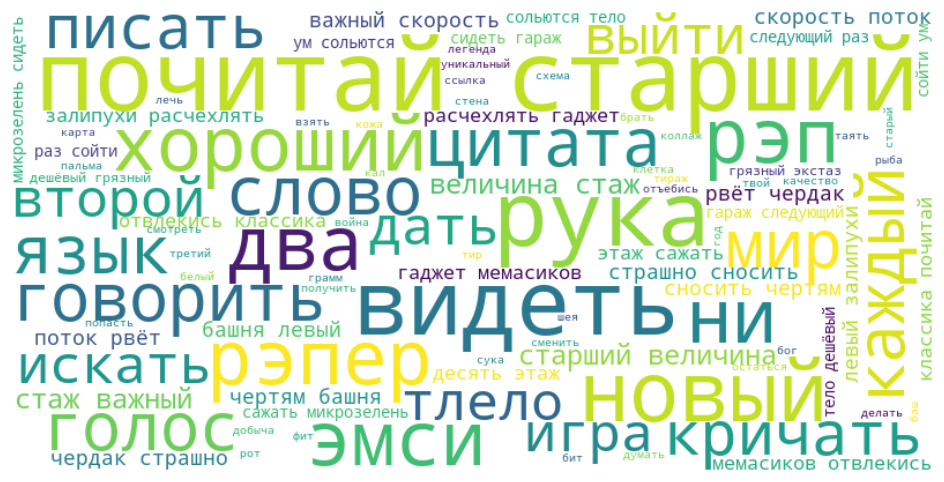

In [168]:
all_text = " ".join([" ".join(tokens) for tokens in texts_lemma])

wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Часть 2: Классификация тональности с помощью BERT

IMDB Dataset https://disk.yandex.ru/d/dhKpEgM4rQkLiQ;

In [ ]:
# 1. Data preparation:
# Loading IMDB Dataset https://disk.yandex.ru/d/dhKpEgM4rQkLiQ;
# Text Preprocessing;
# Train/Test Split;

### 4. Используйте предварительно обученную модель BERT для классификации тональности отзывов о фильмах

Вес задания: 20%

In [ ]:
# Тонкая настройка BERT: обучите модель на обучающем наборе данных и оцените ее качество на тестовом наборе данных;
# Оценка метрик:
# Точность
# Точность/Полнота
# F1-мера


# **Описание задания**

**2. Сравните TF-IDF с другими методами векторизации текста, такими как Count Vectorizer, Word2Vec или Doc2Vec. (Вес задачи: 30%)**

⚡️Критерии сравнения:
* Вычислительная сложность
* Качество представления
* Интерпретируемость

Результат части 2:
* ✅ Было проведено сравнение трех методов векторизации в соответствии с указанными критериями сравнения;

Снижение оценки:
* Избыточное количество таблиц и графиков без пояснений;
* Реализовано менее трех методов;
* Не все критерии сравнения реализованы;

**3. Проведите исследование, используя полученные преобразованные данные.

Какие слова/фразы встречаются чаще всего, а какие реже (вес задачи: 20%)**

Результаты части 3:
Выполнен статистический анализ текста;

* ✅ Выполнен статистический анализ текста;
* Отображение 10 наиболее часто встречающихся слов;
* Отображение 10 наиболее часто встречающихся сочетаний слов;
* ✅ Графическая визуализация (t-sne, WordCloud);

Выводы:
* Нет выводов относительно сравнения;
* Графики/таблицы не сравнивались;

**4. Используйте предварительно обученную модель BERT для
классификации тональности отзывов о фильмах. (Вес задачи: 20%)**


Execution algorithm::
* ✅ 1.Data preparation:
*   Loading IMDB Dataset https://disk.yandex.ru/d/dhKpEgM4rQkLiQ;
*   Text Preprocessing;
*   Train/Test Split;
* ✅ 2. Работа с BERT:
* Загрузите предварительно обученную модель BERT и соответствующий ей токенизатор с сайта Hugging Face:
* Hugging Face Transformers
* Токенизация
* Создание классификатора
* Подготовка данных: используйте токенизатор BERT для преобразования текстов в формат входных данных модели (входные идентификаторы, маски внимания и т. д.).

* ✅ 3. Обучение модели BERT:
* Тонкая настройка BERT: обучите модель на обучающем наборе данных и оцените ее качество на тестовом наборе данных;
* Оценка метрик:
* Точность
* Точность/Полнота
* F1-мера

Результаты части 4:
* ✅ Точность на тестовом наборе данных не ниже заданного порогового значения (например, 0,9).
* ✅ F1-мера для положительного класса близка к точности, что указывает на баланс между точностью и полнотой.
* ✅ Модель корректно различает явно положительные и явно отрицательные отзывы при ручной проверке примеров.
* ✅ Результаты стабильны при повторном разделении на обучающую и тестовую выборки (значительного снижения показателей не наблюдается).
* ✅ Время вывода на один отзыв достаточно короткое для практического использования (например, доли секунды на типичном GPU/CPU).
* ✅ Алгоритм обучения модели на основе задачи завершен;
* ✅ Все данные должны сопровождаться выводами, основанными на полученных результатах исследования (2-3 предложения);
